In [221]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [222]:
import numpy as np
import pandas as pd

In [223]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [224]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [225]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [226]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [227]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [228]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [229]:
#Get column names
columns = inspector.get_columns('measurement')
print(columns)
columns1 = inspector.get_columns('station')
print(columns1)

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]
[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 

In [230]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

2017-08-23
2016-08-23


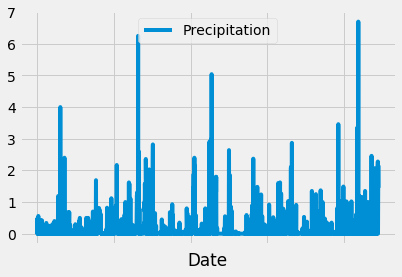

In [231]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

latest = session.query(Measurements.date).order_by(Measurements.date.desc()).limit(1).all()
latest = latest[0][0] #trim value from returend list
print(latest)
#print(dt.date.today()-dt.timedelta(days=365))
session.query(Measurements.date).\
    filter((func.strftime("%Y", Measurements.date) == latest[0:4])\
           | ((func.strftime("%Y", Measurements.date) == str(int(latest[0:4])-1))\
           & (func.strftime("%m", Measurements.date) > latest[5:7]))).\
    order_by(Measurements.date.desc()).all()
                                        
# Calculate the date 1 year ago from the last data point in the database

lastdate = dt.date(int(latest[0:4]),int(latest[5:7]),int(latest[8:10]))-dt.timedelta(days=365)
print(lastdate)

# Perform a query to retrieve the date and precipitation scores

results = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > lastdate).order_by(Measurements.date.desc()).all()
#    group_by(Measurements.date).\
    


# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.fillna(value=0, inplace=True)

# Sort the dataframe by date

df.sort_values(by =['Date'], ascending=True).head(10)


# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

![precipitation](Images/precipitation.png)

In [232]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2 = pd.DataFrame({'Count': df.count(),'Mean': df.mean(),'Std':df.std(),'Min':df.min(),'25%':df.quantile(.25),'50%':df.quantile(.5),'75%':df.quantile(.75),'Max':df.max()})

df2.T


,Precipitation
Count,2223.000000
Mean,0.159951
Std,0.441220
Min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
Max,6.700000


![describe](Images/describe.png)

In [233]:
# Design a query to show how many stations are available in this dataset?

session.query(Measurements.station).group_by(Measurements.station).count()

9

In [234]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

df3 = session.query(Measurements.station, func.count(Measurements.station)).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()
df3

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [235]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
LoHiAve = [0,0,0]

df4 = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
    filter(Measurements.station == df3[0][0]).all()
print(df4)


[(54.0, 85.0, 71.66378066378067)]


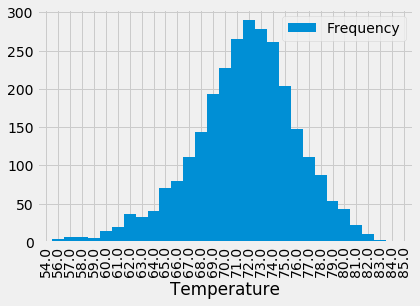

In [236]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
interval = (max[0][0]-min[0][0])/11

results = session.query(Measurements.tobs, func.count(Measurements.tobs)).\
    filter((Measurements.station == df3[0][0]) and (Measurements.date > lastdate)).\
    group_by(Measurements.tobs).\
    order_by(Measurements.tobs.asc()).all()

df6 = pd.DataFrame(results, columns=['Temperature', 'Frequency'])
df6.set_index('Temperature', inplace=True)
#print(df6)
df6.plot.bar(width=1)

        

![precipitation](Images/station-histogram.png)

In [237]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).\
        filter(Measurements.date <= end_date).all()

def calc_rain(start_date, end_date):
    return session.query(func.min(Measurements.prcp), func.avg(Measurements.prcp), func.max(Measurements.prcp)).\
        filter(Measurements.date >= start_date).\
        filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))
print(calc_rain('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]
[(0.0, 0.7043137254901962, 6.24)]


In [238]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

triptemps = calc_temps('2017-05-05', '2017-06-06')
print(triptemps)

[(66.0, 75.6931216931217, 87.0)]


75.6931216931217


Text(0,0.5,'Temp (F)')

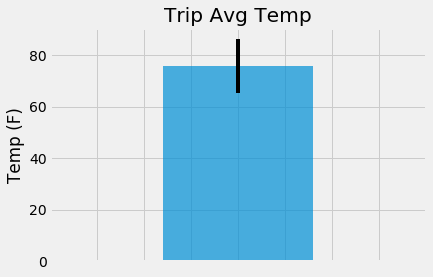

In [239]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = (triptemps[0][2]-triptemps[0][0])/2
print(triptemps[0][1])
plt.bar(1,triptemps[0][1], yerr=error, alpha=.7)
plt.xlim(0,2)
plt.title('Trip Avg Temp')
plt.tick_params(axis='x',which='both',bottom=False, top=False, labelbottom=False)
plt.ylabel('Temp (F)')

In [240]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

df7 = session.query(Measurements.station, Stations.name, func.sum(Measurements.prcp), Stations.latitude, Stations.longitude, Stations.elevation).\
        filter(Measurements.station == Stations.station).\
        filter(Measurements.date >= '2017-05-05').\
        filter(Measurements.date <= '2017-06-06').\
        group_by(Measurements.station).\
        order_by(func.sum(Measurements.prcp).desc()).all()
df7 = pd.DataFrame(df7, columns=['Station','Name','Precipitation','Lat','Long','Elev'])
df7

,Station,Name,Precipitation,Lat,Long,Elev
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",9.75,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",6.14,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",4.42,21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2.76,21.52130,-157.83740,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.68,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.77,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [241]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
from flask import Flask, jsonify

In [ ]:
app = Flask(__name__)

In [ ]:
@app.route("/")
def index():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end><br/>"
    )

In [ ]:
@app.route("/api/v1.0/precipitation")
def precipitation():
latest = session.query(Measurements.date).order_by(Measurements.date.desc()).limit(1).all()
latest = latest[0][0] #trim value from returend list

lastdate = dt.date(int(latest[0:4]),int(latest[5:7]),int(latest[8:10]))-dt.timedelta(days=365)

results = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > lastdate).\
    group_by(Measurements.date).\
    order_by(Measurements.date.desc()).all()

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.fillna(value=0, inplace=True)

df.sort_values(by =['Date'], ascending=True).head(10)
Newdict = df.to_json

return jsonify(Newdict)

In [ ]:
@app.route("/api/v1.0/stations")
def stations():
results = session.query(Stations.station, Stations.name).\
    group_by(Stations.station).all()

dfs = pd.DataFrame(results, columns=['Station', 'Name'])
dfs.set_index('Station', inplace=True)

dfs.sort_values(by =['Station'], ascending=True).head(10)
Newdict = dfs.to_json

return jsonify(Newdict)

In [ ]:
@app.route("/api/v1.0/tobs")
def tobs():

latest = session.query(Measurements.date).order_by(Measurements.date.desc()).limit(1).all()
latest = latest[0][0] #trim value from returend list

lastdate = dt.date(int(latest[0:4]),int(latest[5:7]),int(latest[8:10]))-dt.timedelta(days=365)

results = session.query(Measurements.date, Measurements.tobs, Measurements.station).\
    filter(Measurements.date > lastdate).\
    order_by(Measurements.date.desc()).all()

df = pd.DataFrame(results, columns=['Date', 'Temperature Observations','Station'])
df.set_index('Date', inplace=True)
df.fillna(value=0, inplace=True)

df.sort_values(by =['Date'], ascending=True).head(10)
Newdict = df.to_json

return jsonify(Newdict)

In [ ]:
@app.route("/api/v1.0/<start_date>")
def start():

results = session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).all()
df = pd.DataFrame(results, columns=['TMin', 'TAvg','TMax'])

Newdict = df.T.to_json

return jsonify(Newdict)

In [ ]:
@app.route("/api/v1.0/<start_date>/<end_date>")
def startend():
    
results = session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).\
        filter(Measurements.date <= end_date).all()
df = pd.DataFrame(results, columns=['TMin', 'TAvg','TMax'])

Newdict = df.T.to_json

return jsonify(Newdict)

In [ ]:
if __name__ == "__main__":
    app.run(debug=True)